In [1]:
import sys
sys.path.append("../lib/")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, ticker

from DalitzModel import *
from BWRes import *

%matplotlib inline
plt.rc('animation', html='html5')
plt.rc('text', usetex=True)
plt.rc('font', size=18)

In [2]:
degtorad = np.pi / 180.

In [3]:
def plot_ddist(mab, mbc, bins=200, num=None):
    """ Scatter plot of Dalitz distribution """
    fig = plt.figure(num=num, figsize=(8,6))
    ax = fig.add_subplot(111)
    hist = ax.hist2d(mab, mbc, bins=bins, cmap=plt.cm.PuBu)
    fig.colorbar(hist[3], ax=ax, pad=0.02)

In [4]:
def phsp_edge(phsp, rtype1, rtype2):
    """ Calculate phase space edges """
    mr1_min, mr1_max = phsp.mass_sq_range[rtype1]
    mr1_space = np.linspace(mr1_min, mr1_max, 1000)
    mr2_mins, mr2_maxs = phsp.mr_sq_range(rtype2, mr1_space, rtype1)
    mr1 = np.concatenate([mr1_space, mr1_space[::-1]])
    mr2 = np.concatenate([mr2_mins, mr2_maxs[::-1]])
    return [mr1, mr2]

In [5]:
def show_phase_space(phsp, rtype1, rtype2, num=None, color=None):
    """ Plot phase space edge """
    if color is None:
        color = 'blue'
    mr1, mr2 = phsp_edge(phsp, rtype1, rtype2)
    mr1_range = max(mr1) - min(mr1)
    mr2_range = max(mr2) - min(mr2)
    fig = plt.figure(num=num)
    plt.plot(mr1, mr2, linestyle='-', color=color)
    plt.gca().set_xlabel(r'$m^{2}_{\mathrm{' + rtype1 + r'}}\ (GeV^{2}/c^{4})$')
    plt.gca().set_ylabel(r'$m^{2}_{\mathrm{' + rtype2 + r'}}\ (GeV^{2}/c^{4})$')
    plt.axis('equal')
    plt.tight_layout()
    plt.xlim(0, 1.05*max(mr1))
    plt.ylim(0, 1.05*max(mr2))

In [6]:
model = DalitzModel(.475, .135, .135, 1.865)
model.add_bw('rho(770)', .770, .1490, 1, 'BC')
model.add_bw('K*', .89166, 0.0508, 1, 'AB', 0.638*np.exp(1j*133.2*degtorad))

In [7]:
print model

Phase space D -> ABC, where
 mD = 1.865, mA = 0.475, mB = 0.135, mC = 0.135


In [8]:
def plot_density_countours(msq1g, msq2g, dens, num=None, figsize=None, nlevels=25, cmap=plt.cm.PuBu):
    fig = plt.figure(num=num, figsize=figsize)
    levels = np.linspace(0, max(dens.flatten()), nlevels)
#     CS = plt.contourf(msq1g, msq2g, dens, cmap=cmap, levels=levels)
    CS = plt.contour(msq1g, msq2g, dens, cmap=cmap, levels=levels)
    plt.colorbar(CS)

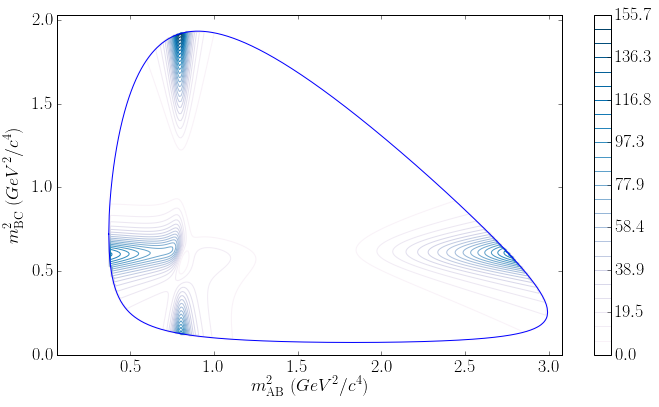

In [9]:
msq1g, msq2g, dens = model.grid_dens('AB', 'BC', 250)
plot_density_countours(msq1g, msq2g, dens, 6, (10, 6))
show_phase_space(model, 'AB', 'BC', 6, 'blue')

In [10]:
mab_sq_range = model.mass_sq_range['AB']
mab_sq_range

[0.37209999999999999, 2.9929000000000001]

In [11]:
# dens = model.density(1., 1.)
# dens

In [12]:
majorant = model.assess_majorant()
majorant

238.44230100793726

In [13]:
rtype1, rtype2 = 'AB', 'BC'
mab_sq, mbc_sq = model.sample(10**6, rtype1, rtype2)

43448 events generated
86935 events generated
130132 events generated
173369 events generated
216652 events generated
259653 events generated
302915 events generated
346359 events generated
389613 events generated
432868 events generated
476134 events generated
519104 events generated
562396 events generated
605438 events generated
648733 events generated
692043 events generated
735065 events generated
778391 events generated
821351 events generated
864333 events generated
907671 events generated
950790 events generated
993839 events generated
1036782 events generated


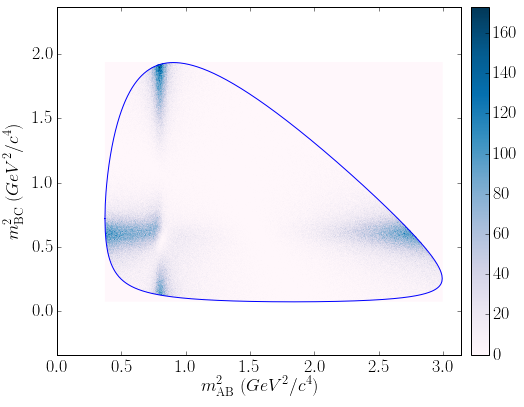

In [14]:
plot_ddist(mab_sq, mbc_sq, 400, 5)
show_phase_space(model, rtype1, rtype2, 5)

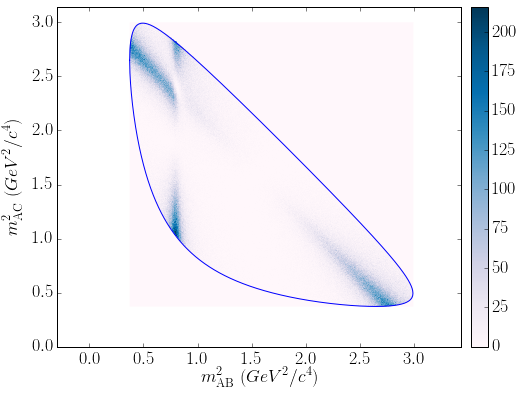

In [15]:
mac_sq = model.third_mass_sq(mab_sq, mbc_sq)
plot_ddist(mab_sq, mac_sq, 400, 5)
show_phase_space(model, 'AB', 'AC', 5)

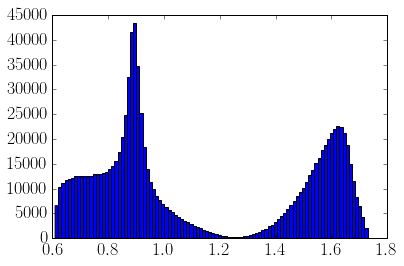

In [16]:
plt.hist(np.sqrt(mab_sq), bins=100);

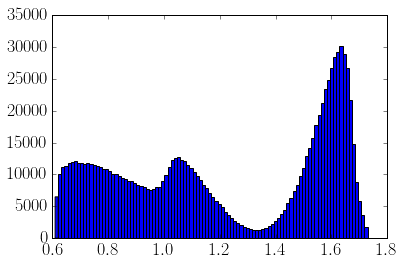

In [17]:
plt.hist(np.sqrt(mac_sq), bins=100);

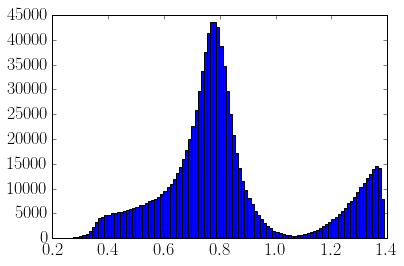

In [18]:
plt.hist(np.sqrt(mbc_sq), bins=100);

## Animated interference

In [19]:
from matplotlib import animation

In [20]:
# FIG = plt.figure(num=9, figsize=(10, 6))
# AXES = plt.axes()
# show_phase_space(model, 'AB', 'BC', 9, 'blue')
# plt.grid()
# plt.title(r'$\rho(770)$ -- $K^*(892)$ interference')
# plt.close()

In [21]:
import types
def setvisible(self,vis):
    for c in self.collections: c.set_visible(vis)
def setanimated(self,ani):
    for c in self.collections: c.set_animated(ani)

In [22]:
def animate(i):
    """ Init frame """
    plt.figure(num=9)
    model.rdict['K*']['ampl'] *= np.exp(1j * np.pi / 100)
    dens = model.density(msq1g, msq2g, 'AB', 'BC')
    levels = np.linspace(0, max(dens.flatten()), 25)
#     plt.title(r'$\rho(770)$ -- $K^*(892)$ interference, K^* phase = {}'.format(np.angle(model.rdict['K*']['ampl'])))
    cont = AXES.contourf(msq1g, msq2g, dens, cmap=plt.cm.PuBu, levels=levels)
    text = 'title=' + str(i)
    te = AXES.text(90,90,str(text))
    an = AXES.annotate(str(text), xy=(0.45, 1.05), xycoords='axes fraction')
    cont.set_visible = types.MethodType(setvisible, cont)
    cont.set_animated = types.MethodType(setanimated, cont)
    return [cont,te,an], str(i)

In [23]:
FIG = plt.figure(num=9, figsize=(10, 6))
AXES = plt.axes()
show_phase_space(model, 'AB', 'BC', 9, 'blue')
plt.grid()
plt.title(r'$\rho(770)$ -- $K^*(892)$ interference')
plt.close()

In [24]:
ims = []
for i in range(200):
    model.rdict['K*']['ampl'] *= np.exp(1j * np.pi / 100)
    dens = model.density(msq1g, msq2g, 'AB', 'BC')
    levels = np.linspace(0, max(dens.flatten()), 25)
    cont = AXES.contourf(msq1g, msq2g, dens, cmap=plt.cm.PuBu, levels=levels)
    add_arts = cont.collections
    text = ''
    te = AXES.text(90,90,str(text))
    an = AXES.annotate(str(text), xy=(0.45, 1.05), xycoords='axes fraction')
    ims.append(add_arts + [te,an])

<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollection objects>
<a list of 24 mcoll.PathCollecti

In [25]:
ani = animation.ArtistAnimation(FIG, ims, interval=20, blit=True)

In [26]:
ani